In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import random
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing
import math
from scipy.spatial.distance import euclidean as eu

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from scipy import signal

Collecting the data into Dyslexic and Control

In [5]:
D_path = glob.glob('Data/Dyslexic' + "/*")
C_path = glob.glob('Data/Control' + "/*")

C_data = []
for path in C_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    C_data.append(temp)
    
D_data = []
for path in D_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    D_data.append(temp)

new_vals() - takes the eye tracking readings from the left and right eye and combines it into a single array of complex numbers

In [3]:
def new_vals(data):
    x = [sum(x) for x in zip(data['LX'].to_list(), data['RX'].tolist())]
    y = [sum(x) for x in zip(data['LY'].to_list(), data['RY'].tolist())]
    
    compl = np.array([complex(a,b) for a,b in zip(x, y)])
    
    return compl

binning() - maps a vector any lenght to a vector of a fixed length(bins) as needed.  This helps to compare vectors of various lengths. Each entry of the resulting vector is a sum of fixed number of elements of the input vector. Few of these elements are considered common for successive entries into the resulting vector. This is the overlapping factor. 


So the fixed number of elements considered for the each entry = (lenght of input vector/lenght of output vector) + overlap

In [6]:
def binning(bins, fft, overlap_per):
    div_size = len(fft)/bins
    bin_size = div_size*(1+(overlap_per/100))
    half_bin = bin_size/2
    
    binned = []
    
    current_step = bin_size
    for a in range(bins):
        
        pos = np.ceil(half_bin + a*(div_size))
        start = 0 if a == 0 else int(np.ceil(pos - half_bin))
        end = -1 if a == (bins-1) else int(np.ceil(pos + half_bin))
        #print([start, end])
        
        binned = np.append(binned, sum(np.abs(fft[start : end]))) 
        
    return binned

kmeans_binning() - kmeans clustering of the binned vectors. 

In [7]:
def kmeans_binning(D_data,C_data, bins, bins_per):
    
    data_sets = [D_data,C_data]
    all_buckets = []
    for dataset in data_sets:
        for no in range(len(dataset)):
            d = new_vals(dataset[no])
            fft = np.fft.fft(d)   

            binned = binning(bins, fft, bins_per)
            all_buckets.append(binned)
            buckets = np.asarray(all_buckets)
            
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(buckets)
    predicted_labels = kmeans.labels_
    actual_labels = np.concatenate((np.ones(98), np.zeros(88)))
    
    conf_m = confusion_matrix(actual_labels,predicted_labels)[:2]
    acc = accuracy_score(actual_labels,predicted_labels)*100
    
    return conf_m, acc

In [8]:
conf, a = kmeans_binning(D_data,C_data, 1000, 10)

In [10]:
a

69.35483870967742

In [11]:
vals1 = np.load('accuracy_vals.npy')

In [14]:
D_path = glob.glob('Data\Dyslexic' + "\*")
C_path = glob.glob('Data\Control' + "\*")

C_data = []
for path in C_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    C_data.append(temp)

D_data = []
for path in D_path:
    temp = pd.read_csv(path)
    temp = temp.drop('Unnamed: 0',axis = 1)
    D_data.append(temp)
C_new = []
for data in C_data:
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    C_new.append(f)
D_new = []
for data in D_data:
    X =data[['LX','RX']]
    Y =data[['LY','RY']]
    Xm = X.mean(axis=1)
    Ym = Y.mean(axis=1)
    f = pd.DataFrame([data.iloc[:,0],Xm,Ym])
    f = f.transpose()
    f = f.rename(columns = {'Unnamed 0': 'X', 'Unnamed 1': 'Y'})
    D_new.append(f)

### Creating trial versions    
C_cmx = []
C_real= []
C_img=[]
for j in range(len(C_new)):
    dat = C_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    
    
    C_cmx.append(z)
    C_real.append(x_in)
    C_img.append(y_in)
D_cmx = []
D_real= []
D_img=[]
for j in range(len(D_new)):
    dat = D_new[j]
    x = dat['X']
    y = dat['Y']
    t = dat['T']
    
    z=[]
    x_in=[]
    y_in=[]
    for i in range(0,x.size):
        z.append(complex(x[i],y[i]))
        x_in.append(x[i])
        y_in.append(y[i])
    D_cmx.append(z)
    D_real.append(x_in)
    D_img.append(y_in)

In [22]:
def stft_run(D_in,C_in, n, f):
    tmat=[]
    for i in range(88):
        tmat.append(C_cmx[i])
    for i in range(97):
        tmat.append(D_cmx[i])
    C_spec = []
    for j in range(len(tmat)):
        data = tmat[j]
        L= len(data)+1
        k = int((len(data) + 1)/250) # k varies from 4 to 8
        N=20
        B  = L/125
        E =0#round((N*B - L)/(N-1))
        f, t, Zxx = signal.stft(tmat[j],fs= L/50, nperseg=B,noverlap= E,nfft=400)
        P = plt.pcolormesh(t, f, np.abs(Zxx)**2 ,vmax=max(np.abs(data)),shading='gouraud')
        C_spec.append(np.abs(Zxx)**2)
    vec = []
    for i in range(len(C_spec)):
        vec.append(C_spec[i])
    #print(C_spec[i].shape)
    
    for i in range(len(C_spec)):
        vec[i]=vec[i].flatten()
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(vec)
    predicted_labels = kmeans.labels_
    actual_labels = np.concatenate((np.ones(88), np.zeros(97)))
    conf_m = confusion_matrix(actual_labels,predicted_labels)[:2]
    acc = accuracy_score(actual_labels,predicted_labels)*100
    
    return conf_m, acc

C:\Python\Python37\lib\site-packages\scipy\signal\spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


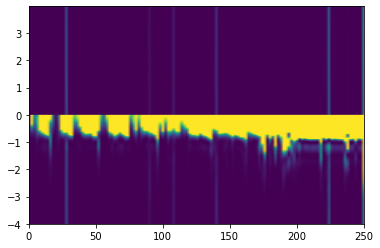

In [16]:
conf, a = stft_run(D_real,C_real, 400, 250)

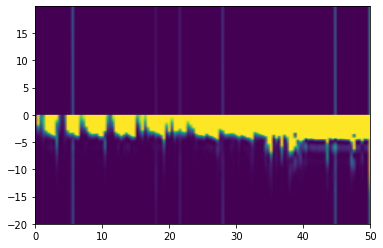

In [23]:
conf, a = stft_run(D_real,C_real, 400, 50)

In [19]:
a

61.08108108108108